In [1]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sys
import itertools
from collections import namedtuple
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 1
%aimport analyze

with open('plots/style.json') as f:
    mpl.rcParams.update(json.load(f))

In [2]:
summit = analyze.Analysis('results/summit')
print(summit)

Analysis for Celeritas v0.1.2+fb3f5506 on summit


In [89]:
inp = summit.load_results(('testem3-flat','orange','gpu'), 0)['input']
primaries_per_event = inp['primary_gen_options']['primaries_per_event']
def calc_event_rate(summary):
    event_rate = analyze.inverse_summary(summary['avg_time_per_primary'])
    event_rate['mean'] /= primaries_per_event
    event_rate['std'] /= primaries_per_event
    return event_rate

In [60]:
summit.result.columns

Index(['action_times', 'active_hwm', 'avg_steps_per_primary',
       'avg_time_per_primary', 'avg_time_per_step', 'emptying_step',
       'num_primaries', 'num_step_iters', 'num_steps', 'pre_emptying_time',
       'queue_hwm', 'slot_occupancy', 'total_time', 'unconverged', 'exception',
       'failure'],
      dtype='object')

In [3]:
summed = analyze.summarize_instances(summit.result[[
    'avg_steps_per_primary',
    'avg_time_per_primary',
    'avg_time_per_step',
    'num_steps',
    'total_time',
    'unconverged',
    'slot_occupancy']])

In [4]:
summed[('total_time', 'mean')].unstack()

arch                                  cpu        gpu
problem              geo                            
cms2018              vecgeom    97.170656  10.502121
cms2018+field+msc    vecgeom  1524.499513  63.749321
simple-cms+field     orange           NaN        NaN
simple-cms+field+msc orange           NaN        NaN
                     vecgeom   128.032990  19.713483
simple-cms+msc       orange     76.817336   3.564495
testem15             orange     51.319575   2.452065
testem15+field       orange     57.467580   2.278443
testem15+field+msc   orange     74.056602   2.418891
                     vecgeom    71.973009   2.570924
testem3-flat         orange     92.433950   3.479560
                     vecgeom    88.407367   3.911422
testem3-flat+field   orange    126.237160   3.706364
testem3-flat+msc     orange    194.957597   6.968619

In [5]:
rel_err = summed.xs('std', axis=1, level=1) / summed.xs('mean', axis=1, level=1)
high_err = rel_err > 0.02
rel_err[high_err].dropna(how='all').dropna(how='all', axis=1)

avg_time_per_primary  avg_time_per_step  \
problem              geo     arch                                            
cms2018              vecgeom gpu               0.032770           0.032485   
simple-cms+field+msc vecgeom cpu               0.055442           0.052778   
                             gpu               0.487321           0.487208   
simple-cms+msc       orange  gpu               0.083089           0.083043   
testem15+field       orange  gpu               0.132725           0.132779   
testem15+field+msc   orange  gpu               0.134800           0.134767   
                     vecgeom gpu               0.116093           0.116124   
testem3-flat         orange  gpu               0.083192           0.083131   
                     vecgeom cpu               0.027352           0.027381   
                             gpu               0.059092           0.058964   
testem3-flat+field   orange  gpu               0.075610           0.075662   
testem3-flat+msc     orange  gpu                    NaN                NaN   

                                   total_time  unconverged  slot_occupancy  
problem              geo     arch                                           
cms2018              vecgeom gpu     0.032770          NaN        0.094579  
simple-cms+field+msc vecgeom cpu     0.055442     0.918937        0.223344  
                             gpu     0.487321     0.271586             NaN  
simple-cms+msc       orange  gpu     0.083089          NaN        0.040383  
testem15+field       orange  gpu     0.132725          NaN        0.024262  
testem15+field+msc   orange  gpu     0.134800          NaN             NaN  
                     vecgeom gpu     0.116093          NaN             NaN  
testem3-flat         orange  gpu     0.083192          NaN             NaN  
                     vecgeom cpu     0.027352          NaN             NaN  
                             gpu     0.059092          NaN             NaN  
testem3-flat+field   orange  gpu     0.075610          NaN             NaN  
testem3-flat+msc     orange  gpu          NaN          NaN        0.032396

In [11]:
summed['unconverged']

count           mean          std
problem              geo     arch                                   
cms2018              vecgeom cpu     6.0       0.000000     0.000000
                             gpu     6.0       0.000000     0.000000
cms2018+field+msc    vecgeom cpu     6.0  181427.500000  1701.017313
                             gpu     6.0   97231.000000   207.113495
simple-cms+field     orange  cpu     0.0            NaN          NaN
                             gpu     0.0            NaN          NaN
simple-cms+field+msc orange  cpu     0.0            NaN          NaN
                             gpu     0.0            NaN          NaN
                     vecgeom cpu     6.0       1.500000     1.378405
                             gpu     6.0      15.166667     4.119061
simple-cms+msc       orange  cpu     6.0       0.000000     0.000000
                             gpu     6.0       0.000000     0.000000
testem15             orange  cpu     6.0       0.000000     0.000000
                             gpu     6.0       0.000000     0.000000
testem15+field       orange  cpu     6.0       0.000000     0.000000
                             gpu     6.0       0.000000     0.000000
testem15+field+msc   orange  cpu     6.0       0.000000     0.000000
                             gpu     6.0       0.000000     0.000000
                     vecgeom cpu     6.0       0.000000     0.000000
                             gpu     6.0       0.000000     0.000000
testem3-flat         orange  cpu     6.0       0.000000     0.000000
                             gpu     6.0       0.000000     0.000000
                     vecgeom cpu     6.0       0.000000     0.000000
                             gpu     6.0       0.000000     0.000000
testem3-flat+field   orange  cpu     2.0       0.000000     0.000000
                             gpu     5.0       0.000000     0.000000
testem3-flat+msc     orange  cpu     4.0       0.000000     0.000000
                             gpu     4.0       0.000000     0.000000

In [7]:
problems = summit.problems()
p_to_i = dict(zip(problems, itertools.count()))
g_to_color = {'orange': '#F6A75E', 'vecgeom': '#5785B7'}
arch_to_shape = {'gpu': 'x', 'cpu': 'o'}

In [8]:
problem_to_abbr = {'testem15': 'A',
 'testem15+field': 'AF',
 'testem15+field+msc': 'AFM',
 'simple-cms+msc': 'B',
 'simple-cms+field': 'BF',
 'simple-cms+field+msc': 'BFM',
 'testem3-flat': 'C',
 'testem3-flat+field': 'CF',
 'testem3-flat+msc': 'CM',
 'cms2018': 'Z',
 'cms2018+field+msc': 'ZFM'}
# TODO: revert when rerunning to get updated 
# problem_abbr = [problem_to_abbr[k] for k in problems]
problems = list(problem_to_abbr.keys())
p_to_i = dict(zip(problems, itertools.count()))
problem_abbr = list(problem_to_abbr.values())
print('\n'.join('\t'.join([v, k]) for (k, v) in problem_to_abbr.items()))

A	testem15
AF	testem15+field
AFM	testem15+field+msc
B	simple-cms+msc
BF	simple-cms+field
BFM	simple-cms+field+msc
C	testem3-flat
CF	testem3-flat+field
CM	testem3-flat+msc
Z	cms2018
ZFM	cms2018+field+msc


In [9]:
def plot_results(ax, summary):
    index = np.array([p_to_i[p]
                      for p in summary.index.get_level_values('problem')], dtype=float)
    index += [(0.1 if g == 'orange' else -0.05)
              for g in summary.index.get_level_values('geo')]
    color = np.array([g_to_color[g]
                      for g in summary.index.get_level_values('geo')])
    
    if 'arch' in summary.index.names:
        slc_mark = [(a.upper(), summary.index.get_level_values('arch') == a, arch_to_shape[a])
                    for a in ['cpu', 'gpu']]
        
    else:
        slc_mark = [(None, slice(None), 's')]

    result = []
    for lab, slc, mark in slc_mark:
        temp_idx = index[slc]
        temp_sum = summary.loc[slc]
        ax.errorbar(temp_idx, temp_sum['mean'], temp_sum['std'],
                    capsize=0, fmt='none', ecolor=(0.2,)*3)
        scat = ax.scatter(temp_idx, temp_sum['mean'], c=color[slc], marker=mark,
                         label=lab)
        result.append(scat)
    
    xax = ax.get_xaxis()
    xax.set_ticks(np.arange(len(problems)))
    xax.set_ticklabels(problem_abbr, rotation=90)
    grid = ax.grid()
    ax.set_axisbelow(True)
    return scat

In [15]:
speedup = analyze.get_cpugpu_ratio(summed['total_time'])
fig, ax = plt.subplots()
plot_results(ax, speedup)
ax.set_ylabel("Speedup (7-CPU / 1-GPU wall time)")
analyze.annotate_metadata(ax, summit);
fig.savefig('plots/speedups.pdf', transparent=True)
plt.close()

In [81]:
fig, axes = plt.subplots(nrows=2, figsize=(4,4), subplot_kw=dict(yscale='log'))
for (ax, q) in zip(axes, ['step', 'primary']):
    plot_results(ax, analyze.inverse_summary(summed['avg_time_per_' + q]))
    ax.set_ylabel(q + ' per sec')
    ax.legend()
fig.savefig('plots/steps-vs-primaries.png', dpi=300)
plt.close()

In [90]:
(fig, (time_ax, occ_ax)) = plt.subplots(
    nrows=2, figsize=(4, 4),
    gridspec_kw=dict(height_ratios=[3, 1])
)
time_ax.set_yscale('log')
plot_results(time_ax, calc_event_rate(summed))
time_ax.set_ylabel(r"Event rate [1/s]")
time_ax.legend()
time_ax.set_xticklabels([])
plot_results(occ_ax, summed['slot_occupancy'])
occ_ax.set_ylabel("Slot occupancy")
analyze.annotate_metadata(ax, summit)
fig.savefig('plots/rate-occupancy.pdf', transparent=True)
plt.close()

In [25]:
speedup.dropna().applymap("{:.1f}".format)

mean  std
problem              geo               
cms2018              vecgeom   9.3  0.3
cms2018+field+msc    vecgeom  23.9  0.4
simple-cms+field+msc vecgeom   6.5  3.2
simple-cms+msc       orange   21.6  1.8
testem15             orange   20.9  0.2
testem15+field       orange   25.2  3.4
testem15+field+msc   orange   30.6  4.1
                     vecgeom  28.0  3.3
testem3-flat         orange   26.6  2.2
                     vecgeom  22.6  1.5
testem3-flat+field   orange   34.1  2.6
testem3-flat+msc     orange   28.0  0.2

## Action fraction pie charts


In [26]:
mean_action_times = summit.action_times().xs('mean', axis=1, level=1).T
mean_action_times.sort_index(inplace=True)

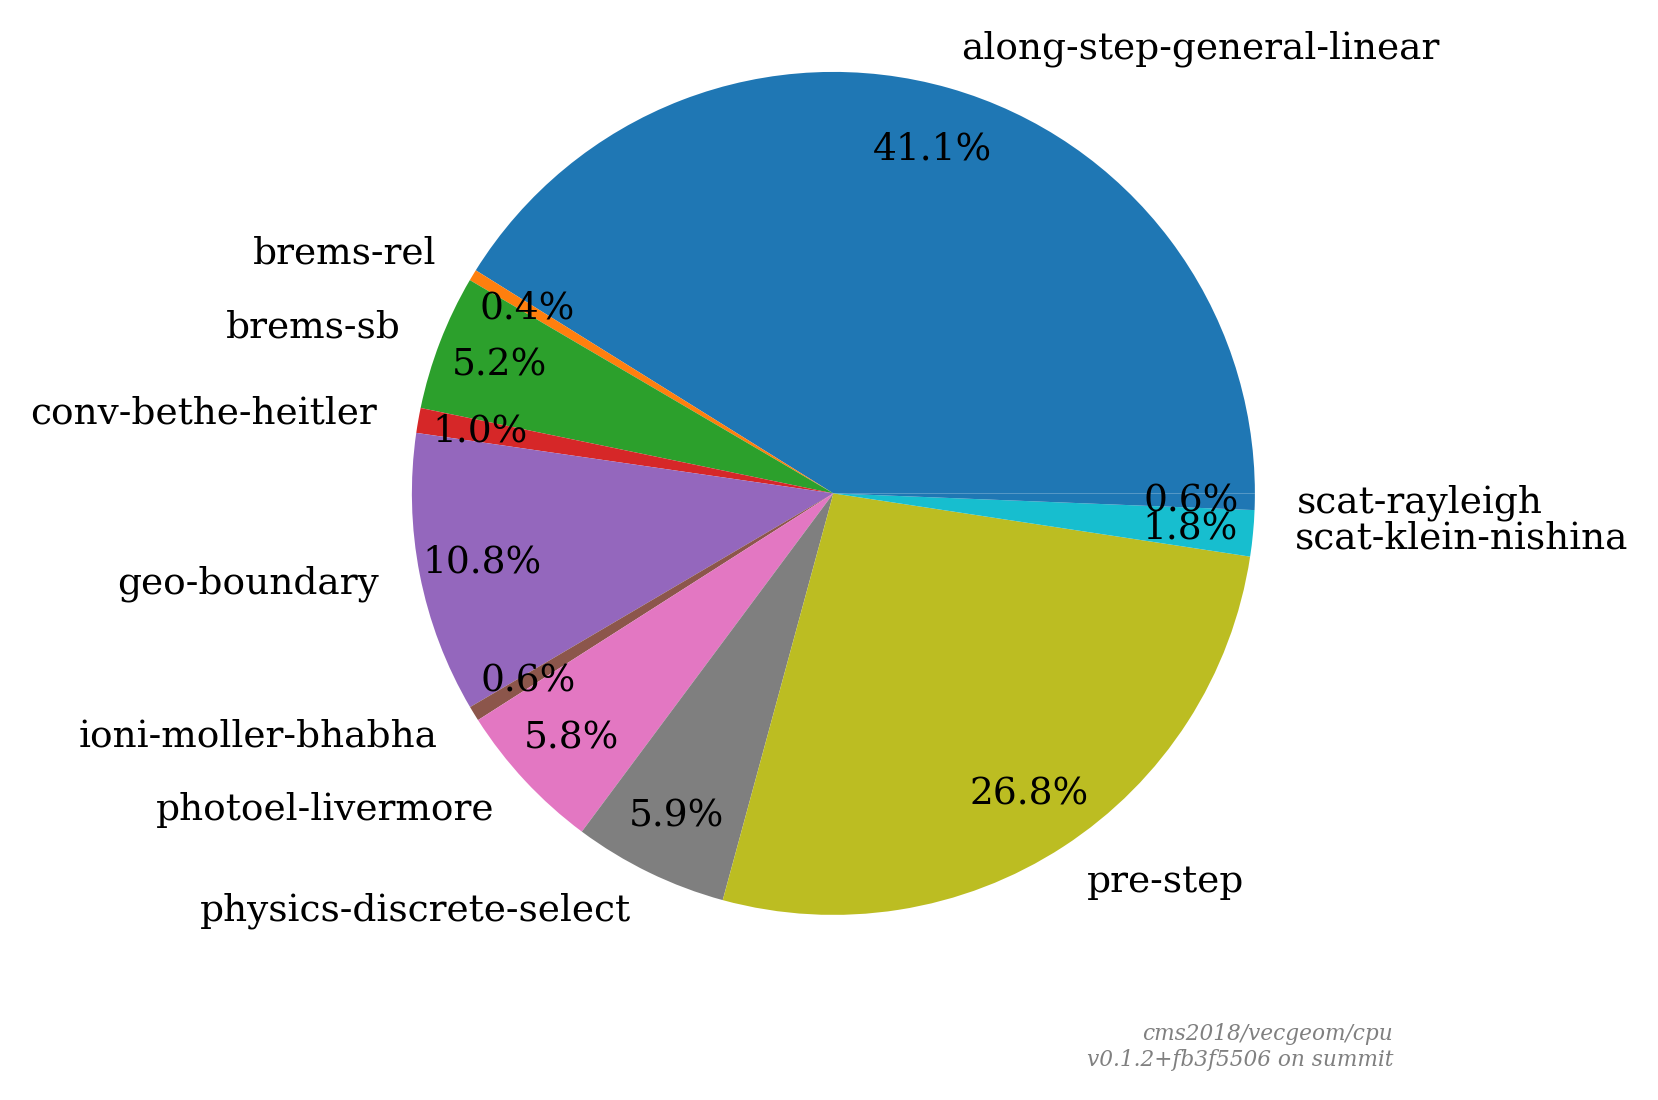

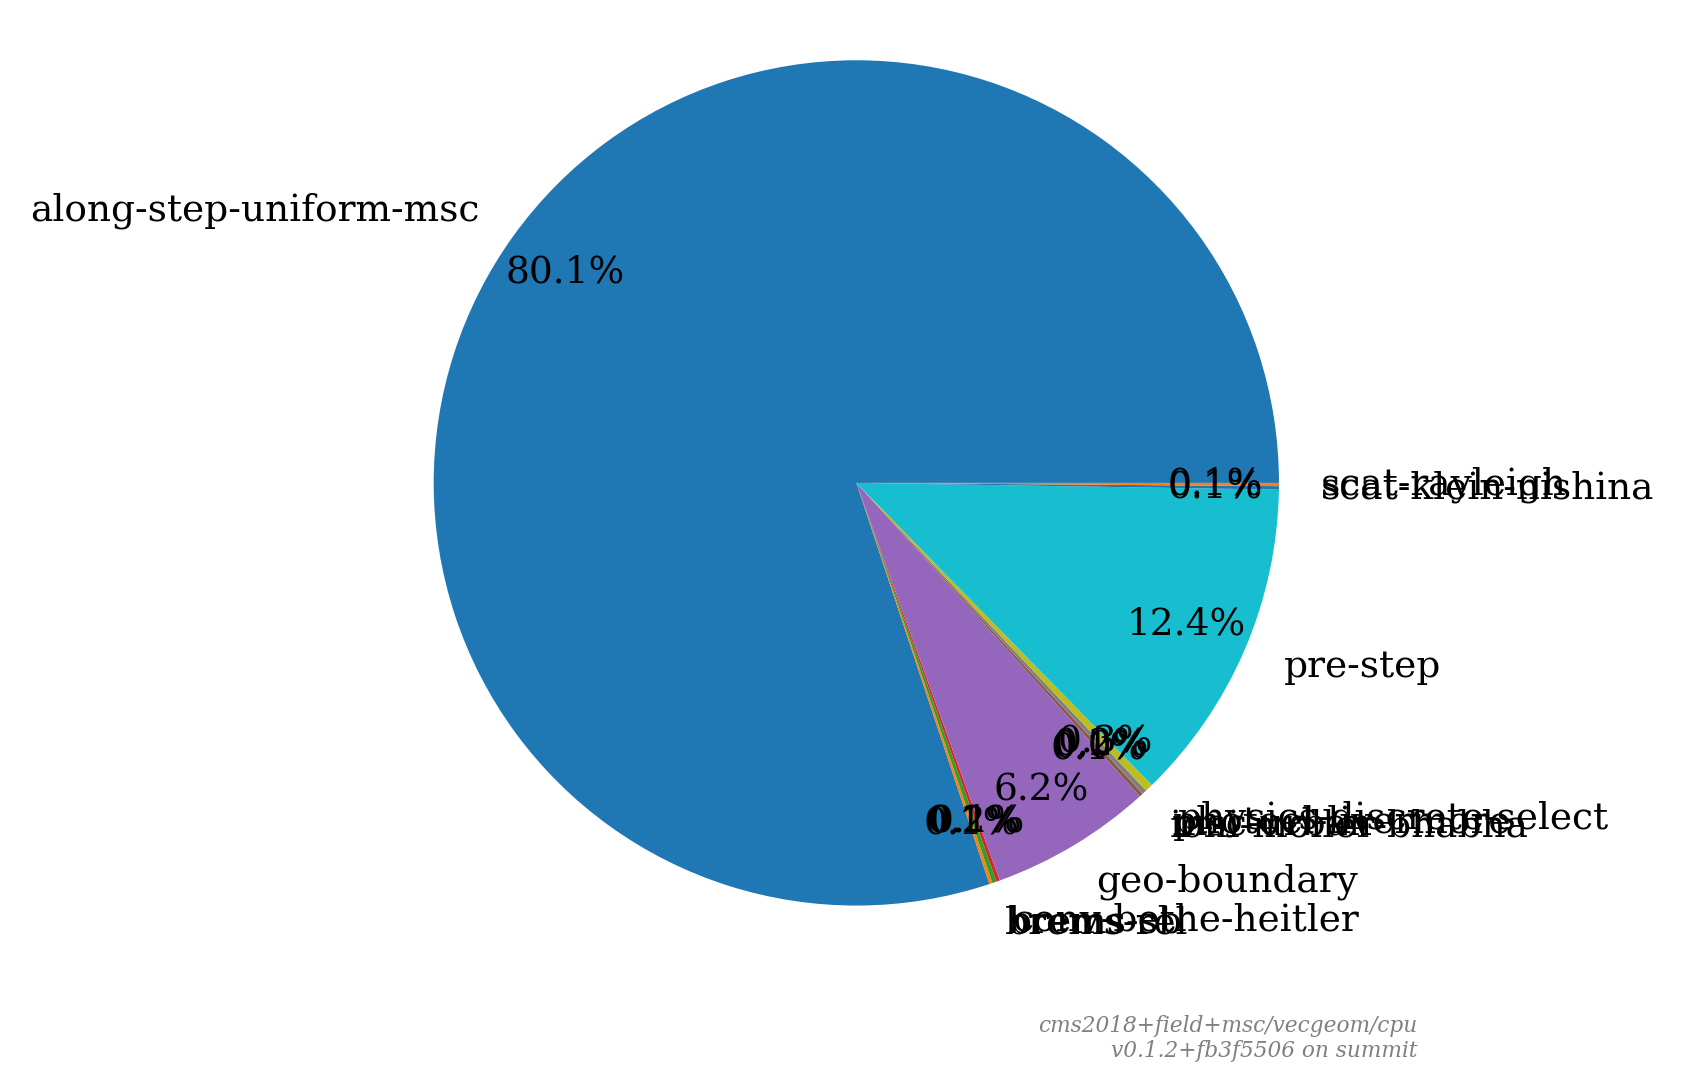

In [101]:
for ext in ["", "+field+msc"]:
    prob_geo = ('cms2018'+ext, 'vecgeom')
    temp = mean_action_times.xs(prob_geo, axis=1, level=('problem', 'geo')).dropna()

    for (arch, series) in temp.iteritems():
        (fig, ax) = plt.subplots(figsize=(4, 4))
        ax.pie(series, labels=series.index, autopct='%1.1f%%', pctdistance=0.85)
        ax.axis('equal')
        name = prob_geo + (arch,)
        slashname = "/".join(name)
        fig.text(
            0.98, 0.02, f"{slashname}\n{summit.version} on {summit.system}",
            va='bottom', ha='right',
            fontstyle='italic', color=(0.5,)*3, size='xx-small',
            zorder=-100
        )
        dashname = "-".join(name)
    fig.savefig(f'plots/{dashname}.pdf', transparent=True)
    plt.close()

### Plot per-step timing on GPU

In [28]:
cms = [summit.load_results((p, 'vecgeom', 'gpu'), 0)
       for p in ['cms2018', 'cms2018+field+msc']]

for plot, label in [(analyze.plot_counts, 'counts'),
                    (analyze.plot_accum_time, 'time')]:
    (fig, axes) = plt.subplots(ncols=2, figsize=(8, 2))
    
    for (i, ax, data) in zip(itertools.count(), axes, cms):
        objs = plot(ax, data)
        analyze.annotate_metadata(ax, data['_metadata'])
        if i == 0:
            objs['oax'].set_ylabel(None)
        elif i == 1:
            objs['ax'].set_ylabel(None)
    fig.savefig(f'plots/cms-{label}.pdf', transparent=True)
    plt.close()

## Crusher

In [29]:
crusher = analyze.Analysis('results/crusher')
print(crusher)

Analysis for Celeritas v0.1.2+fb3f5506 on crusher


In [30]:
csum = analyze.summarize_instances(crusher.result[~crusher.invalid][[
    'avg_steps_per_primary',
    'avg_time_per_primary',
    'avg_time_per_step',
    'num_steps',
    'total_time',
    'unconverged',
    'slot_occupancy',
]])

In [31]:
csum[('total_time', 'mean')].unstack()

,arch,cpu,gpu
problem,geo,,
simple-cms+msc,orange,35.638204,2.102885
testem15,orange,24.376470,1.579907
testem15+field,orange,27.648985,1.691097
testem15+field+msc,orange,33.967578,1.993990
testem3-flat,orange,43.112763,3.140767
testem3-flat+field,orange,61.258933,4.331177
testem3-flat+msc,orange,85.938865,4.807194


In [33]:
rel_err = csum.xs('std', axis=1, level=1) / csum.xs('mean', axis=1, level=1)
high_err = rel_err > 0.02
rel_err[high_err].dropna(how='all').dropna(how='all', axis=1)

,,,slot_occupancy
problem,geo,arch,
simple-cms+msc,orange,gpu,0.031625


In [35]:
analyze.get_cpugpu_ratio(csum['total_time'])

,,mean,std
problem,geo,,
simple-cms+msc,orange,16.947294,0.147048
testem15,orange,15.429051,0.104445
testem15+field,orange,16.349737,0.125166
testem15+field+msc,orange,17.034979,0.106581
testem3-flat,orange,13.726827,0.106696
testem3-flat+field,orange,14.143715,0.045445
testem3-flat+msc,orange,17.877137,0.050129


In [50]:
crusher_times

count       mean       std
problem            geo    arch                            
simple-cms+msc     orange cpu     8.0  35.638204  0.093428
                          gpu     8.0   2.102885  0.017394
testem15           orange cpu     8.0  24.376470  0.069405
                          gpu     8.0   1.579907  0.009703
testem15+field     orange cpu     8.0  27.648985  0.050276
                          gpu     8.0   1.691097  0.012576
testem15+field+msc orange cpu     8.0  33.967578  0.063841
                          gpu     8.0   1.993990  0.011899
testem3-flat       orange cpu     8.0  43.112763  0.263944
                          gpu     8.0   3.140767  0.015042
testem3-flat+field orange cpu     5.0  61.258933  0.086288
                          gpu     3.0   4.331177  0.012508
testem3-flat+msc   orange cpu     8.0  85.938865  0.158814
                          gpu     7.0   4.807194  0.010138

In [92]:
crusher_rates = calc_event_rate(csum)
summit_rates = calc_event_rate(summed.loc[crusher_times.index])

counts = {
    ('summit', 'cpu'): 7,
    ('summit', 'gpu'): 1,
    ('crusher', 'cpu'): 8,
    ('crusher', 'gpu'): 1,
}

In [98]:
(crusher_rates['mean'] / summit_rates['mean']).unstack()

,arch,cpu,gpu
problem,geo,,
simple-cms+msc,orange,2.155477,1.695050
testem15,orange,2.105292,1.552031
testem15+field,orange,2.078470,1.347317
testem15+field+msc,orange,2.180214,1.213091
testem3-flat,orange,2.144004,1.107870
testem3-flat+field,orange,2.060714,0.855741
testem3-flat+msc,orange,2.268561,1.449623


In [96]:
fig, ax = plt.subplots()
ax.set_yscale('log')
for offset, color, machine, rates in [(-0.05, '#7A954F', 'Summit', summit_rates),
                                      (0.05, '#BC5544', 'Crusher', crusher_rates)]:
    for arch in ['cpu', 'gpu']:
        summary = rates.xs(arch, level='arch')
        index = np.array([p_to_i[p]
                          for p in summary.index.get_level_values('problem')], dtype=float)
        index += offset
    
        mark = arch_to_shape[arch]
        count = counts[(machine.lower(), arch)]
        arch = arch.upper()
        ax.errorbar(index, summary['mean'], summary['std'],
                    capsize=0, fmt='none', ecolor=(0.2,)*3)
        scat = ax.scatter(index, summary['mean'], c=color, marker=mark,
                         label=f"{machine} ({count} {arch})")    
xax = ax.get_xaxis()
xax.set_ticks(np.arange(len(problems)))
xax.set_ticklabels(problem_abbr, rotation=90)
grid = ax.grid()
ax.set_axisbelow(True)
ax.legend()
ax.set_ylabel(r"Event rate [1/s]")
fig.savefig('plots/crusher-vs-summit.pdf')
plt.close()